# 11.2.2 Interpretability methods to explain black box models

## SHapley Additive exPlanations (SHAP)

More information please visit https://shap.readthedocs.io/en/latest/

#### Load Packages

In [1]:
import numpy as np
import pandas as pd #to work with csv files

from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

#matplotlib imports are used to plot confusion matrices for the classifiers
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 

#import feature extraction methods from sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
#pre-processing of text
import string
import re
from gensim.models import Word2Vec, KeyedVectors
import gensim
import gensim.downloader as gensim_api
#import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

#import time function from time module to track the training duration
from time import time
from collections import OrderedDict

import seaborn as sns
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict

#### Import IMDB dataset

In [21]:
imdb = pd.read_csv('IMDB_Dataset.csv')
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Define a function that performs basic text pre-processing

In [22]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def clean_text(str_list, lemmatize=False):
    clean_list = []
    
    for text in str_list:
        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)
        words = word_tokenize(text)
        clean_words = []
        
        for word in words:            
            if (len(word) > 1) and (re.match(r'^\w+$', word)):
                if lemmatize:
                    lemmatizer = WordNetLemmatizer()
                    word = lemmatizer.lemmatize(word)
                clean_words.append(word)
        clean_text = ' '.join(clean_words)
        clean_list.append(clean_text)
    
    return clean_list

In [23]:
# run on all reviews
imdb['clean_review'] = clean_text(imdb['review'])
imdb.head()

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,positive,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production The filming techni...
2,I thought this was a wonderful way to spend ti...,positive,thought this was wonderful way to spend time o...
3,Basically there's a family where a little boy ...,negative,Basically there family where little boy Jake t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,Petter Mattei Love in the Time of Money is vis...


In [24]:
imdb['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [25]:
# Replace 'positive' by 1 and 'negative' by 0
imdb['sentiment'] = imdb['sentiment'].map(lambda x : 1 if x == 'positive' else 0)
imdb['sentiment']

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

In [26]:
imdb['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

#### Prepare the data matrix ${\bf X}$ as well as the label vector $y$

In [27]:
X = imdb['clean_review'] #the column text contains textual data to extract features from
y = imdb['sentiment'] #this is the column we are learning to predict. 

print(X.shape, y.shape)

(50000,) (50000,)


#### Train a classifier. Here we select logistic regression

In [28]:
#Train a classifier
vect = TfidfVectorizer(lowercase = True,
                        stop_words = 'english',
                        ngram_range = (1,1)) 

X_dtm = vect.fit_transform(X)

classifier = LogisticRegression(penalty="l2", C=0.1) #instantiate a logistic regression model
classifier.fit(X_dtm, y) #fit the model with training data

# Check the training accuracy
y_pred_class = classifier.predict(X_dtm)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y, y_pred_class))

Accuracy:  0.88358


#### Introduce a testing positive sentiment review 

In [29]:
mystring = 'The movie was a true masterpiece, captivating from start to finish with its brilliant storytelling, exceptional performances, and stunning cinematography that left me in awe.'
print(mystring)
true_class = 1

The movie was a true masterpiece, captivating from start to finish with its brilliant storytelling, exceptional performances, and stunning cinematography that left me in awe.


#### Here is where we use SHAP 

In [30]:
# Import SHAP
import shap

# Create a SHAP explainer for the classifier
explainer = shap.Explainer(classifier, X_dtm)

In [31]:
# Transform the text you want to explain into a format suitable for the model
mystring_encoded = vect.transform([mystring])

In [32]:
# Explain the model's prediction for the provided text
shap_values = explainer.shap_values(mystring_encoded)

In [33]:
# Get the expected value (baseline) of the model's output
expected_value = explainer.expected_value

In [34]:
predicted_prob = classifier.predict_proba(mystring_encoded)[0][true_class]

In [35]:
print("Probability (positive) =", predicted_prob)
print("Probability (negative) =", 1 - predicted_prob)
print("True Class is:", true_class)

Probability (positive) = 0.8390385097693956
Probability (negative) = 0.16096149023060435
True Class is: 1


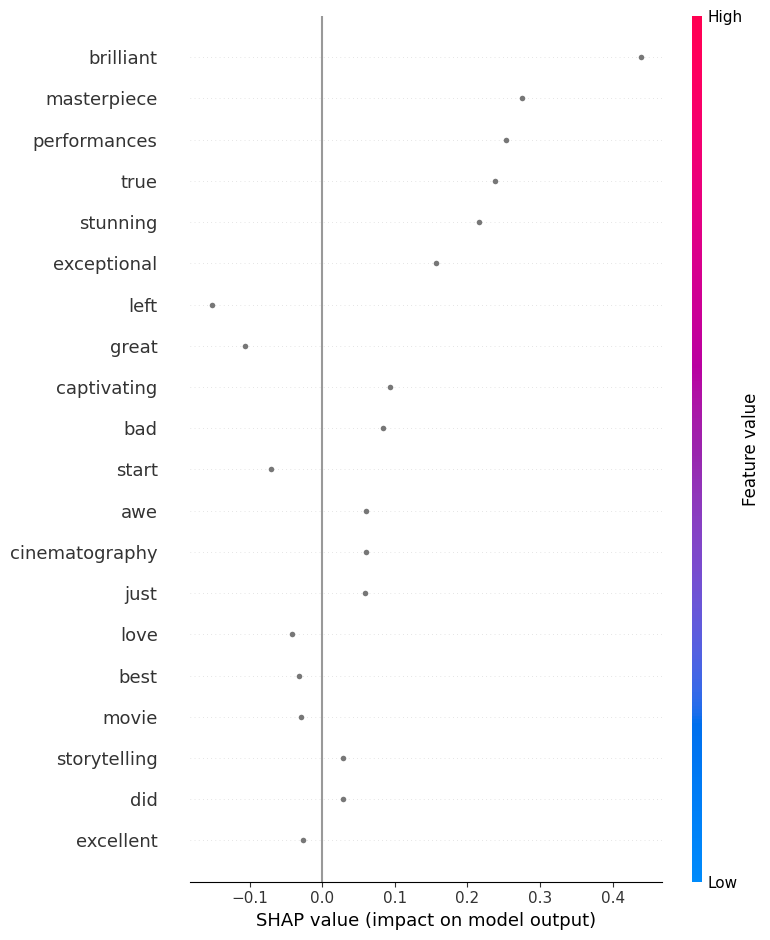

In [36]:
# Visualize the SHAP values
shap.summary_plot(shap_values, mystring_encoded, feature_names=vect.get_feature_names_out())